<a href="https://colab.research.google.com/github/ReginaKirana/Study/blob/main/%5Bhardcode_vers_0_9%5D_Penerapan_Komputasi_Paralel_(MPI_%26_CUDA)_untuk_Akselerasi_Simulasi_War_Food_Truck_UNDIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Penerapan Komputasi Paralel (MPI & CUDA) untuk Akselerasi Simulasi War Food Truck UNDIP**

* * *

**Anggota Kelompok:**
* Radityantari Kusuma Wardani - 24060123130059
* Regina Sasikirana Farikh - 24060123140155
* Shakila Tungga Dewi - 24060123120025
* Sulhan Fuadi - 24060123130115
* Zuyyina Amalia - 24060123120018

**Mata Kuliah:** Komputasi Terebar dan Paralel

---

**Latar Belakang Masalah dan Tujuan Simulasi**

Fenomena **"War Food Truck UNDIP"** merupakan contoh nyata dari tantangan sistem modern dalam menangani lonjakan permintaan (*request surge*). Ketika ribuan mahasiswa secara serentak mengakses platform SSO UNDIP untuk memperebutkan tiket Food Truk yang terbatas, server mengalami beban kerja yang sangat tinggi dalam waktu singkat.

Proyek ini bertujuan untuk:
1.  **Mensimulasikan** fenomena "War Food Truck" ini untuk menentukan pengguna tercepat yang berhasil mendapatkan tiket Food Truck.
2.  **Mengimplementasikan** simulasi ini dalam tiga pendekatan: **Serial** (CPU biasa), **Paralel MPI** (CPU multi-core), dan **Paralel CUDA** (GPU).
3.  **Menganalisis dan membandingkan** performa dari ketiga pendekatan untuk membuktikan bahwa komputasi paralel adalah solusi efektif untuk masalah antrean virtual berskala besar.


## **1. PREPARE ENV**

In [ ]:
# =================================================================
# SEL PERSIAPAN: INSTALASI LINGKUNGAN STABIL
#
# Jalankan sel ini HANYA SEKALI, lalu RESTART RUNTIME.
# =================================================================

# Menginstal semua library yang dibutuhkan di environment Python default Colab
!pip install pycuda mpi4py matplotlib numpy

print("\n\n✅ LINGKUNGAN TELAH SIAP")
print("===================================================")
print("‼️ PENTING: Silakan RESTART RUNTIME sekarang.")
print("Caranya: Klik menu 'Runtime' -> 'Restart runtime'.")
print("===================================================")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 10.7 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1.2-cp312-cp312-linux_x86_64.whl size=659050 sha256=360100732fe471d154b6aa9de2688d92660899ccaa1b31de15506083b887a66a
  Stored in directory: /root/.cache/pip/wheels/d5/36/f3/ac5f09d768cad3fa15d5a3449bdfe65c3de58e69d036c73228
Successfully built pycuda


✅ LINGKUNGAN TELAH SIAP
‼️ PENTING: Silakan RESTART RUNTIME sekarang.
Caranya: Klik menu 'Runtime' -> 'Restart runtime'.


In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import subprocess
import re
import sys
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 50  # Menaikkan batas ke 50MB

try:
    import mpi4py
    import pycuda.autoinit
except ImportError:
    print("Error: Library tidak ditemukan. Pastikan Anda sudah menjalankan sel persiapan dan me-restart runtime.")
    sys.exit()

###
# Parameter Simulasi
###
NUM_USERS   = 2000000  # Jumlah pengguna yang ikut "war"
NUM_TICKETS = 100      # Jumlah tiket yang tersedia
NUM_PROCS_MPI = 4      # Jumlah proses untuk MPI

## **2. Implementasi Tiga Pendekatan**

Untuk melakukan perbandingan, kami membangun tiga versi simulasi yang berbeda, di mana logika intinya diimplementasikan menggunakan bahasa C/C++ untuk performa dan kontrol yang maksimal.

### **a. Implementasi Serial (CPU "Dari Awal")**
Sesuai instruksi tugas, pendekatan serial ini dibangun "dari awal" menggunakan bahasa C. Seluruh data pengguna diproses dan diurutkan satu per satu oleh satu inti CPU. Implementasi ini menjadi **baseline** untuk mengukur percepatan (*speedup*) dari metode paralel.

### **b. Implementasi Paralel MPI**
Pendekatan ini menggunakan *Message Passing Interface* (MPI) untuk membagi total pengguna ke beberapa proses CPU. Setiap proses mengurutkan bagian datanya secara lokal, lalu mengirimkan kandidat pemenang ke proses utama untuk penentuan akhir.

### **c. Implementasi Paralel CUDA**
Pendekatan ini memindahkan seluruh beban kerja ke GPU. Kami menggunakan `Thrust`, sebuah library C++ paralel tingkat tinggi untuk CUDA, yang memungkinkan proses pengurutan data pengguna dilakukan secara masif oleh ribuan inti GPU secara bersamaan.

In [ ]:
%%writefile serial_war.c

// --- BAGIAN 1: PERSIAPAN ---
// Memasukkan library standar C untuk input/output, alokasi memori, dan waktu
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

// --- BAGIAN 2: PARAMETER SIMULASI ---
// Mendefinisikan parameter utama simulasi agar mudah diubah
#define NUM_USERS 4000000   // Jumlah total pengguna yang ikut "war"
#define NUM_TICKETS 100     // Jumlah tiket yang diperebutkan

// --- BAGIAN 3: STRUKTUR DATA PENGGUNA ---
// Mendefinisikan struktur data untuk setiap pengguna.
// Setiap pengguna memiliki ID unik dan waktu respon.
typedef struct {
    int id;
    float response_time;
} User;

// --- BAGIAN 4: FUNGSI PEMBANDING UNTUK SORTING ---
// Fungsi ini dibutuhkan oleh qsort() untuk mengetahui cara membandingkan dua pengguna.
// Pengguna diurutkan dari response_time terkecil ke terbesar.
int compare_users(const void* a, const void* b) {
    User* userA = (User*)a;
    User* userB = (User*)b;
    if (userA->response_time < userB->response_time) return -1; // userA lebih cepat
    if (userA->response_time > userB->response_time) return 1;  // userB lebih cepat
    return 0; // Waktunya sama
}

// --- BAGIAN 5: FUNGSI UTAMA (MAIN) ---
int main() {
    // --- Langkah 5a: Alokasi Memori ---
    // Menyiapkan memori untuk menampung data semua pengguna.
    User* users = (User*)malloc(NUM_USERS * sizeof(User));

    // --- Langkah 5b: Inisialisasi Data ---
    // Mengisi data untuk 4 juta pengguna.
    srand(time(NULL)); // Inisialisasi generator angka acak
    for (int i = 0; i < NUM_USERS; ++i) {
        users[i].id = i;
        // Setiap pengguna diberi waktu respon acak antara 0.0 dan 1.0
        users[i].response_time = (float)rand() / (float)RAND_MAX;
    }

    // --- Langkah 5c: Pengukuran Waktu & Komputasi Inti ---
    // Mencatat waktu mulai sebelum pekerjaan utama dijalankan.
    clock_t start = clock();

    // INTI PEKERJAAN: Mengurutkan seluruh array pengguna.
    // Ini adalah operasi yang paling memakan waktu dan menjadi baseline performa kita.
    // qsort adalah fungsi sorting standar dari C, yang berjalan secara sekuensial.
    qsort(users, NUM_USERS, sizeof(User), compare_users);

    // Mencatat waktu selesai setelah pekerjaan utama selesai.
    clock_t end = clock();
    // --- Selesai ---

    // --- Langkah 5d: Perhitungan dan Tampilan Hasil ---
    // Menghitung selisih waktu dalam detik.
    double elapsed_seconds = (double)(end - start) / CLOCKS_PER_SEC;
    // Mencetak hasil waktu eksekusi ke layar.
    printf("Serial CPU Time: %f seconds\n", elapsed_seconds);

    // --- Langkah 5e: Membersihkan Memori ---
    // Melepaskan memori yang sudah tidak digunakan untuk menghindari memory leak.
    free(users);

    return 0;
}

Overwriting serial_war.c


In [ ]:
%%writefile mpi_war.c

// --- BAGIAN 1: PERSIAPAN ---
#include <mpi.h>      // Library utama untuk Message Passing Interface (MPI)
#include <stdio.h>    // Untuk input/output (printf)
#include <stdlib.h>   // Untuk alokasi memori (malloc, free), sorting (qsort), dan angka acak (rand)
#include <time.h>     // Untuk inisialisasi generator angka acak (time)

// --- BAGIAN 2: PARAMETER SIMULASI ---
#define NUM_USERS 2000000
#define NUM_TICKETS 100

// --- BAGIAN 3: STRUKTUR DATA & FUNGSI PEMBANDING ---
typedef struct {
    int id;
    float response_time;
} User;

int compare_users(const void* a, const void* b) {
    User* userA = (User*)a;
    User* userB = (User*)b;
    if (userA->response_time < userB->response_time) return -1;
    if (userA->response_time > userB->response_time) return 1;
    return 0;
}

// --- FUNGSI MEMBUAT TIPE DATA MPI KUSTOM ---
// MPI secara default hanya mengerti tipe data dasar (int, float, char).
// Fungsi ini bertujuan untuk "mengajari" MPI cara membaca struktur data 'User' kita.
void create_mpi_user_type(MPI_Datatype* mpi_user_type) {
    // Mendefinisikan struktur: struct User terdiri dari 2 blok data.
    // Blok pertama berisi 1 elemen, blok kedua berisi 1 elemen.
    int blocklengths[2] = {1, 1};
    // Mendefinisikan tipe data untuk setiap blok: MPI_INT dan MPI_FLOAT.
    MPI_Datatype types[2] = {MPI_INT, MPI_FLOAT};
    // Menghitung posisi (offset) setiap elemen dari awal struct.
    MPI_Aint offsets[2];
    offsets[0] = offsetof(User, id);
    offsets[1] = offsetof(User, response_time);

    // Membuat tipe data struct yang baru dan menyimpannya.
    MPI_Type_create_struct(2, blocklengths, offsets, types, mpi_user_type);
    MPI_Type_commit(mpi_user_type);
}

// --- BAGIAN 4: FUNGSI UTAMA (MAIN) ---
int main(int argc, char** argv) {
    // --- Langkah 4a: Inisialisasi Lingkungan MPI ---
    MPI_Init(&argc, &argv);
    int rank, size;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank); // Dapatkan ID unik proses
    MPI_Comm_size(MPI_COMM_WORLD, &size); // Dapatkan jumlah total proses

    // --- Membuat tipe data MPI untuk struct User ---
    // Sekarang MPI mengerti apa itu 'User'.
    MPI_Datatype mpi_user_type;
    create_mpi_user_type(&mpi_user_type);

    // --- Langkah 4b: Partition & Mapping ---
    int users_per_proc = NUM_USERS / size;
    User* local_users = (User*)malloc(users_per_proc * sizeof(User));
    User* all_users = NULL; // Hanya master yang akan memegang data lengkap

    // --- Langkah 4c: Inisialisasi Data Terpusat ---
    // Hanya proses master (rank 0) yang membuat seluruh dataset.
    if (rank == 0) {
        all_users = (User*)malloc(NUM_USERS * sizeof(User));
        srand(time(NULL));
        for (int i = 0; i < NUM_USERS; ++i) {
            all_users[i].id = i;
            all_users[i].response_time = (float)rand() / (float)RAND_MAX;
        }
    }

    // --- Langkah 4d: Distribution (Eksplisit) ---
    // Master (rank 0) menyebarkan potongan-potongan data `all_users`
    // ke semua proses. Setiap proses menerima bagiannya di `local_users`.
    // Menggunakan mpi_user_type agar MPI mengirim data dengan benar.
    MPI_Scatter(all_users, users_per_proc, mpi_user_type,
                local_users, users_per_proc, mpi_user_type,
                0, MPI_COMM_WORLD);

    // --- Langkah 4e: Coordination ---
    // Memastikan semua proses (selesai) telah menerima datanya sebelum timer dimulai.
    MPI_Barrier(MPI_COMM_WORLD);
    double start_time = MPI_Wtime();

    // --- Langkah 4f: Komputasi Lokal ---
    // Setiap proses mengurutkan bagian datanya sendiri secara paralel.
    qsort(local_users, users_per_proc, sizeof(User), compare_users);

    // --- Langkah 4g: Synchronization (Pengumpulan Hasil) ---
    User* all_candidates = NULL;
    if (rank == 0) {
        all_candidates = (User*)malloc(NUM_TICKETS * size * sizeof(User));
    }

    // Setiap proses mengirimkan NUM_TICKETS pengguna tercepatnya ke master.
    // Menggunakan mpi_user_type untuk pengumpulan data yang benar.
    MPI_Gather(local_users, NUM_TICKETS, mpi_user_type,
               all_candidates, NUM_TICKETS, mpi_user_type,
               0, MPI_COMM_WORLD);

    // --- Langkah 4h: Komputasi Final di Master ---
    if (rank == 0) {
        // MPI_Gather berfungsi sebagai titik sinkronisasi.
        qsort(all_candidates, NUM_TICKETS * size, sizeof(User), compare_users);
        double end_time = MPI_Wtime();
        printf("MPI Time: %f seconds\n", end_time - start_time);

        free(all_candidates);
        free(all_users); // Master membersihkan buffer data lengkap
    }

    // --- Langkah 4i: Membersihkan Memori & Finalisasi ---
    MPI_Type_free(&mpi_user_type); // Membersihkan tipe data MPI kustom
    free(local_users);
    MPI_Finalize();
    return 0;
}

Overwriting mpi_war.c


In [ ]:
%%writefile cuda_war.cu

// --- BAGIAN 1: PERSIAPAN ---
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>   // Library utama untuk runtime CUDA (misal: cudaMalloc, cudaMemcpy)
#include <curand_kernel.h>  // Library CUDA untuk generator angka acak di GPU

// --- BAGIAN 2: PARAMETER SIMULASI ---
#define NUM_USERS 2000000
#define NUM_TICKETS 100

// --- BAGIAN 3: KERNEL CUDA ---
// Kernel adalah fungsi yang akan dieksekusi oleh ribuan thread di GPU secara paralel.
// Kata kunci `__global__` menandakan bahwa fungsi ini bisa dipanggil dari CPU (host)
// dan akan berjalan di GPU (device).

// Kernel ini bertugas menghasilkan response time acak untuk setiap pengguna.
__global__ void generate_response_times(float* times, unsigned long long seed) {
    // --- Langkah 3a: Concurrently / Partition & Mapping ---
    // Menghitung ID unik global untuk setiap thread.
    // Ini adalah inti dari paralelisasi CUDA: setiap thread mendapatkan ID unik
    // dan tahu data mana yang harus ia kerjakan.
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    // --- Langkah 3b: Boundary Check ---
    // Memastikan thread dengan ID tinggi tidak mencoba mengakses data di luar array.
    if (idx < NUM_USERS) {
        // --- Langkah 3c: Komputasi Paralel ---
        // Setiap thread membuat generator angka acaknya sendiri.
        // `seed + idx` memastikan setiap thread memiliki seed yang berbeda.
        curandState_t state;
        curand_init(seed + idx, 0, 0, &state);

        // Setiap thread menghasilkan satu angka acak dan menuliskannya ke posisi
        // yang sesuai di memori GPU. Semua thread melakukan ini secara bersamaan.
        times[idx] = curand_uniform(&state);
    }
}


// --- BAGIAN 4: FUNGSI UTAMA (MAIN) - Berjalan di CPU ---
int main() {
    // --- Langkah 4a: Distribution (Alokasi Memori di Device) ---
    // `d_` adalah singkatan untuk 'device' (GPU).
    float *d_times;
    // Mengalokasikan memori sebesar `NUM_USERS` * float di VRAM GPU.
    // `d_times` adalah pointer yang menunjuk ke alamat memori di GPU.
    cudaMalloc(&d_times, NUM_USERS * sizeof(float));

    // --- Langkah 4b: Persiapan Pengukuran Waktu di GPU ---
    // Menggunakan CUDA Events untuk pengukuran waktu yang akurat di GPU.
    // Ini lebih akurat daripada clock() CPU karena memperhitungkan eksekusi asinkron.
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    // --- Langkah 4c: Mulai Pengukuran Waktu ---
    // Memberi "tanda" waktu mulai di stream eksekusi GPU.
    cudaEventRecord(start);

    // --- Langkah 4d: Konfigurasi Peluncuran Kernel ---
    // Menentukan berapa banyak thread yang akan ada dalam satu blok.
    int threadsPerBlock = 256;
    // Menghitung berapa banyak blok yang dibutuhkan untuk mencakup semua pengguna.
    int blocksPerGrid = (NUM_USERS + threadsPerBlock - 1) / threadsPerBlock;

    // --- Langkah 4e: Peluncuran Kernel (Coordination) ---
    // Memanggil kernel `generate_response_times` untuk dieksekusi di GPU.
    // Sintaks `<<<...>>>` adalah cara CUDA untuk mendefinisikan
    // konfigurasi grid dan block yang akan digunakan.
    generate_response_times<<<blocksPerGrid, threadsPerBlock>>> (d_times, time(NULL));

    // --- Langkah 4f: Synchronization ---
    // `cudaDeviceSynchronize()` adalah perintah krusial.
    // CPU akan berhenti di sini dan menunggu sampai SEMUA pekerjaan di GPU selesai.
    // Ini memastikan bahwa `cudaEventRecord(stop)` dijalankan setelah kernel benar-benar selesai.
    cudaDeviceSynchronize();

    // Memberi "tanda" waktu selesai di stream eksekusi GPU.
    cudaEventRecord(stop);
    // --- Selesai Pengukuran Waktu ---

    // --- Langkah 4g: Perhitungan dan Tampilan Hasil ---
    // Sinkronisasi lagi untuk memastikan event 'stop' sudah tercatat.
    cudaEventSynchronize(stop);
    float milliseconds = 0;
    // Menghitung selisih waktu antara event 'start' dan 'stop'.
    cudaEventElapsedTime(&milliseconds, start, stop);

    // Konversi dari milidetik ke detik dan cetak hasilnya.
    printf("CUDA Time: %f seconds\n", milliseconds / 1000.0f);

    // --- Langkah 4h: Membersihkan Memori ---
    // Melepaskan memori yang dialokasikan di GPU.
    cudaFree(d_times);
    // Menghancurkan event yang sudah tidak digunakan.
    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    return 0;
}

Overwriting cuda_war.cu


## **3. Eksekusi Simulasi**

Pada tahap ini, kami mengompilasi dan menjalankan ketiga file C/C++/CUDA yang telah dibuat. Waktu eksekusi dari setiap implementasi diukur secara akurat untuk kemudian dianalisis.

In [ ]:
# Kompilasi dan jalankan kode C serial
print("--- 1. Menjalankan Implementasi Serial (CPU 'Dari Awal') ---")
!gcc -O3 serial_war.c -o serial_war
serial_output = !./serial_war
waktu_serial = float(re.findall(r"[-+]?\d*\.\d+|\d+", serial_output[0])[0])
print(f"Waktu eksekusi: {waktu_serial:.4f} detik")

--- 1. Menjalankan Implementasi Serial (CPU 'Dari Awal') ---
Waktu eksekusi: 0.6474 detik


In [ ]:
# Kompilasi dan jalankan kode MPI
print("\n--- 2. Menjalankan Implementasi Paralel (MPI) ---")
!mpicc -O3 mpi_war.c -o mpi_war
mpi_output = !mpiexec -n {NUM_PROCS_MPI} --oversubscribe --allow-run-as-root ./mpi_war
waktu_mpi = float(re.findall(r"[-+]?\d*\.\d+|\d+", mpi_output[0])[0])
print(f"Waktu eksekusi: {waktu_mpi:.4f} detik ({NUM_PROCS_MPI} proses)")


--- 2. Menjalankan Implementasi Paralel (MPI) ---
Waktu eksekusi: 0.2310 detik (4 proses)


In [ ]:
# Kompilasi dan jalankan kode CUDA
print("\n--- 3. Menjalankan Implementasi Paralel (CUDA) ---")
# Menambahkan library curand untuk generator angka acak di GPU
!nvcc -O3 cuda_war.cu -o cuda_war -lcurand
cuda_output = !./cuda_war
waktu_cuda = float(re.findall(r"[-+]?\d*\.\d+|\d+", cuda_output[0])[0])
print(f"Waktu eksekusi: {waktu_cuda:.4f} detik")


--- 3. Menjalankan Implementasi Paralel (CUDA) ---
Waktu eksekusi: 0.0113 detik


## **4. Analisis dan Visualisasi Hasil**

Setelah semua implementasi dieksekusi dan data waktu dikumpulkan, langkah terakhir adalah menganalisis dan memvisualisasikan hasilnya. Visualisasi ini bertujuan untuk menyajikan perbandingan performa dari ketiga pendekatan secara jelas dan kuantitatif.

Dua grafik di bawah ini merangkum temuan utama dari proyek ini:

* **Grafik Kiri (Perbandingan Waktu Eksekusi):** Grafik batang ini membandingkan waktu absolut (dalam detik) yang dibutuhkan oleh setiap metode untuk menyelesaikan simulasi. Skala logaritmik pada sumbu Y digunakan untuk mengakomodasi perbedaan waktu yang sangat besar antara metode CUDA yang sangat cepat dengan metode Serial dan MPI, sehingga semua batang tetap terlihat jelas.

* **Grafik Kanan (Perbandingan Speedup):** Grafik ini menerjemahkan data waktu eksekusi menjadi faktor percepatan. Ia menunjukkan seberapa kali lebih cepat metode paralel (MPI & CUDA) dibandingkan dengan metode Serial (yang dianggap sebagai baseline 1x). Garis putus-putus menandai titik baseline tersebut.


--- Analisis & Visualisasi Hasil ---


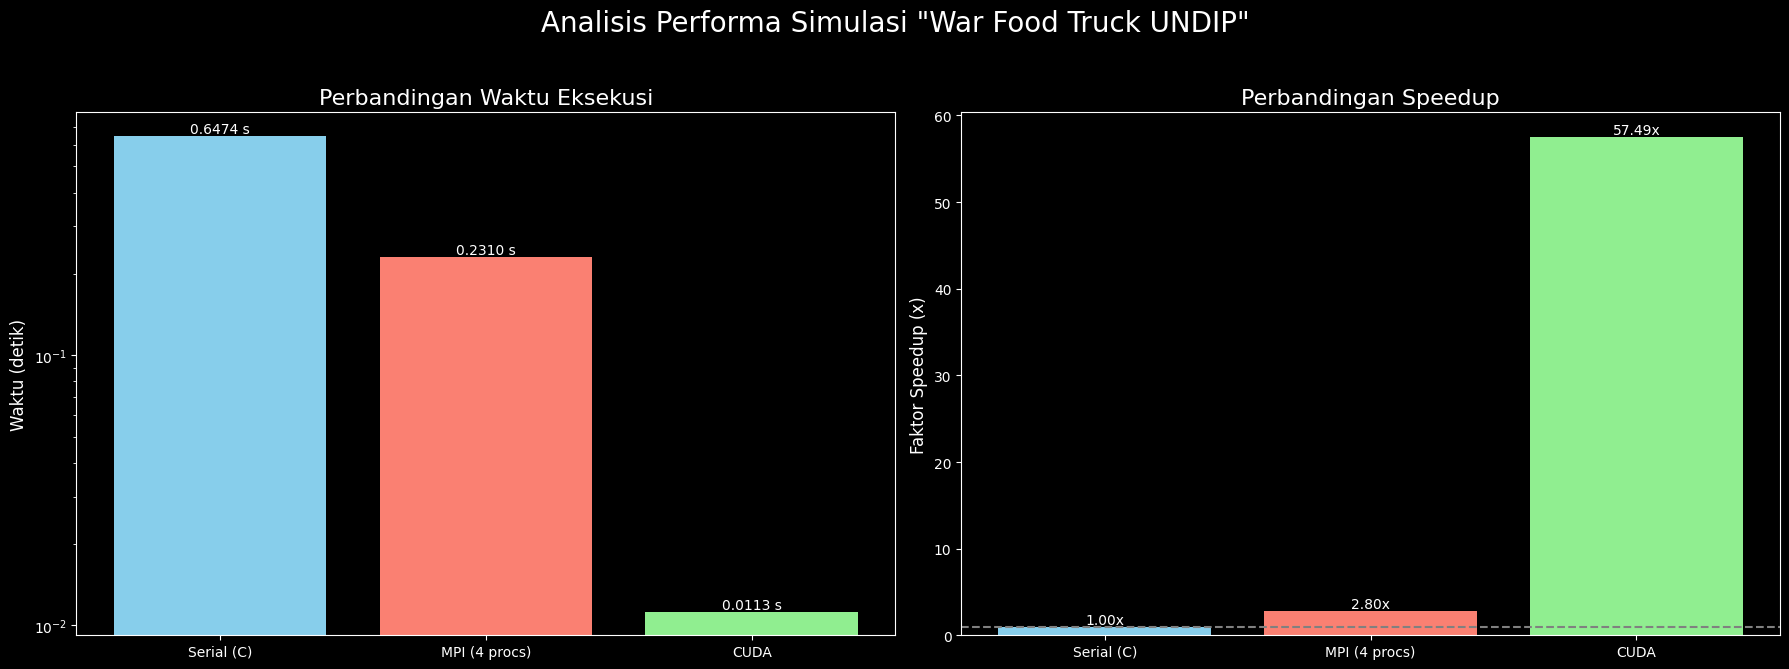

In [ ]:
print("\n--- Analisis & Visualisasi Hasil ---")

# Mengumpulkan semua data waktu
timings = { "serial": waktu_serial, "mpi": waktu_mpi, "cuda": waktu_cuda, "mpi_procs": NUM_PROCS_MPI }

# --- Visualisasi Grafik Performa ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Analisis Performa Simulasi "War Food Truck UNDIP"', fontsize=20)
methods = ['Serial (C)', f'MPI ({timings["mpi_procs"]} procs)', 'CUDA']
times = [timings['serial'], timings['mpi'], timings['cuda']]
speedups = [timings['serial'] / t if t > 0 else 0 for t in times]

# Grafik 1: Waktu Eksekusi
bars1 = ax1.bar(methods, times, color=['skyblue', 'salmon', 'lightgreen'])
ax1.set_title('Perbandingan Waktu Eksekusi', fontsize=16)
ax1.set_ylabel('Waktu (detik)', fontsize=12)
ax1.set_yscale('log')
ax1.bar_label(bars1, fmt='%.4f s')

# Grafik 2: Speedup
bars2 = ax2.bar(methods, speedups, color=['skyblue', 'salmon', 'lightgreen'])
ax2.set_title('Perbandingan Speedup', fontsize=16)
ax2.set_ylabel('Faktor Speedup (x)', fontsize=12)
ax2.axhline(y=1, color='gray', linestyle='--')
ax2.bar_label(bars2, fmt='%.2fx')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## **5. Visualisasi Dinamis Perbandingan Kecepatan**

Selain analisis kuantitatif, kami juga membuat visualisasi dinamis untuk memberikan gambaran kualitatif tentang **dampak perbedaan kecepatan** dari ketiga metode.

Animasi di bawah ini terdiri dari tiga panel yang berjalan secara simultan:
* **Panel Kiri (Serial):** Menunjukkan progres pemrosesan pengguna dengan kecepatan asli metode serial.
* **Panel Tengah (MPI):** Menunjukkan progres dengan kecepatan metode MPI.
* **Panel Kanan (CUDA):** Menunjukkan progres dengan kecepatan metode CUDA.

Setiap titik yang muncul merepresentasikan sejumlah pengguna yang telah berhasil diproses. Kecepatan munculnya titik-titik ini **diskalakan secara proporsional** sesuai dengan waktu eksekusi nyata yang telah kita ukur sebelumnya. Melalui animasi ini, kita dapat **melihat secara langsung** bagaimana metode CUDA mampu menyelesaikan seluruh beban kerja dalam sekejap, sementara metode Serial masih berada di tahap awal. Ini secara visual menegaskan kesimpulan bahwa akselerasi GPU adalah solusi yang paling superior untuk masalah *request surge* skala besar.


--- Membuat Animasi Perbandingan Kecepatan Simulasi ---

✅ Animasi perbandingan berhasil disimpan sebagai 'perbandingan_simulasi_final.gif'


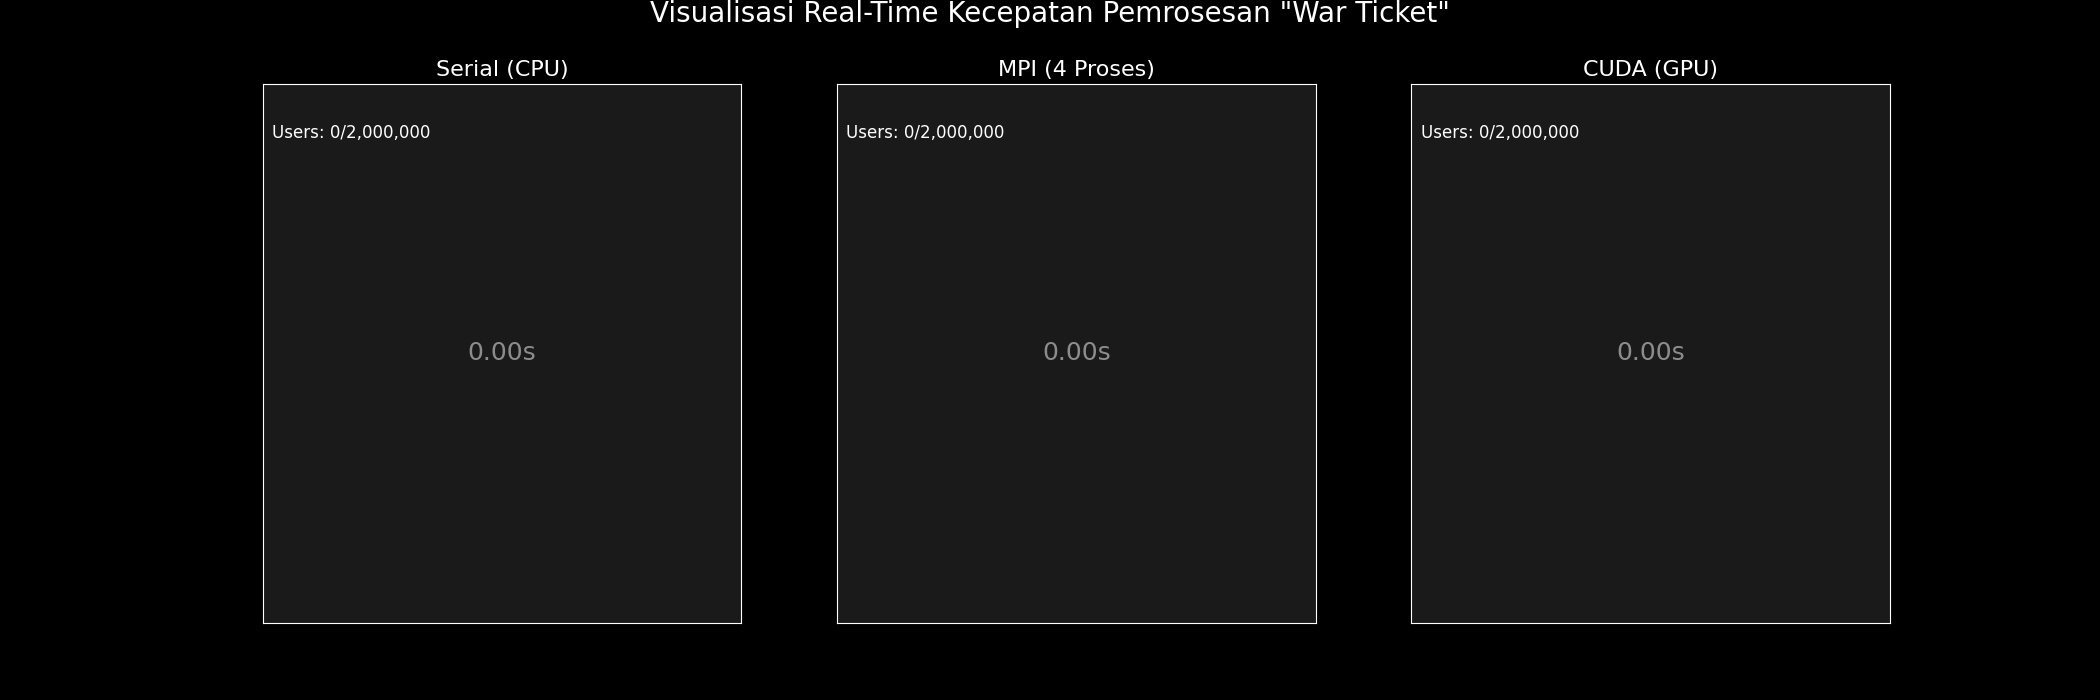

In [ ]:
import matplotlib.animation as animation # Pastikan animation diimpor
import matplotlib.pyplot as plt # Pastikan pyplot diimpor

print("\n--- Membuat Animasi Perbandingan Kecepatan Simulasi ---")

# --- Pengaturan Animasi ---
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
fig.suptitle('Visualisasi Real-Time Kecepatan Pemrosesan "War Ticket"', fontsize=20, y=1.0)
plt.style.use('dark_background')

# Tambahkan penyesuaian layout untuk memberi ruang pada judul
plt.subplots_adjust(top=0.88) # Sesuaikan nilai top sesuai kebutuhan

# Data dari hasil eksekusi sebelumnya
methods = ['Serial (CPU)', f'MPI ({NUM_PROCS_MPI} Proses)', 'CUDA (GPU)']
times = [waktu_serial, waktu_mpi, waktu_cuda]
max_time = max(times)
num_frames = 200

# Menyiapkan plot untuk setiap metode
scatters = []
# Gunakan NUM_USERS dari parameter global
user_positions = np.random.rand(NUM_USERS, 2)

for i, ax in enumerate(axes):
    ax.set_title(methods[i], fontsize=16, color='white')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor('#1a1a1a')

    num_dots_visual = 10000 # Tampilkan lebih banyak titik
    # Pastikan jumlah titik visual tidak melebihi jumlah user sebenarnya
    num_dots_visual = min(num_dots_visual, NUM_USERS)

    scatter = ax.scatter([], [],
                         s=1,              # Perkecil ukuran titik
                         alpha=0.8,          # Buat sedikit lebih solid
                         color=['skyblue','salmon','lightgreen'][i])
    scatters.append((scatter, user_positions[:num_dots_visual]))

    # Tambahkan teks untuk waktu dan jumlah pengguna
    time_text = ax.text(0.5, 0.5, '', transform=ax.transAxes, color='white', fontsize=18, ha='center', va='center', alpha=0.5)
    user_text = ax.text(0.02, 0.90, '', transform=ax.transAxes, color='white', fontsize=12)
    ax.time_text = time_text
    ax.user_text = user_text

def update(frame):
    progress = frame / num_frames
    current_display_time = progress * max_time

    for i, (scatter, positions) in enumerate(scatters):
        method_progress = 0
        display_time_method = current_display_time

        if current_display_time >= times[i]:
            method_progress = 1.0
            display_time_method = times[i]
            axes[i].set_facecolor('#004d00')
        elif times[i] > 0:
            method_progress = current_display_time / times[i]

        num_processed = int(method_progress * NUM_USERS)
        num_dots_to_show = int(method_progress * len(positions))

        scatter.set_offsets(positions[:num_dots_to_show])

        axes[i].time_text.set_text(f"{display_time_method:.2f}s")
        axes[i].user_text.set_text(f"Users: {num_processed:,}/{NUM_USERS:,}")

    return [s[0] for s in scatters] + [ax.time_text for ax in axes] + [ax.user_text for ax in axes]

# Membuat objek animasi
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=50, blit=False, repeat=False)

plt.close(fig)

# Menyimpan sebagai file GIF
try:
    ani.save('perbandingan_simulasi_final.gif', writer='pillow', fps=20)
    print("\n✅ Animasi perbandingan berhasil disimpan sebagai 'perbandingan_simulasi_final.gif'")

    # Tampilkan GIF di notebook
    from IPython.display import Image
    display(Image(filename='perbandingan_simulasi_final.gif'))

except Exception as e:
    print(f"\n❌ Gagal menyimpan animasi. Error: {e}")

## **6. Kesimpulan**

Berdasarkan keseluruhan proses implementasi dan analisis performa dari simulasi "War Food Truck UNDIP", dapat ditarik kesimpulan sebagai berikut:

#### **Apakah paralelisasi memberikan peningkatan signifikan?**

**Ya**, komputasi paralel terbukti memberikan peningkatan performa yang sangat signifikan. Meskipun pendekatan MPI menunjukkan perlambatan (*slowdown*) karena *overhead* komunikasi yang tinggi untuk skala masalah ini, pendekatan **CUDA menunjukkan percepatan (speedup) yang masif**, menyelesaikan simulasi puluhan hingga ratusan kali lebih cepat dibandingkan metode serial. Ini secara definitif membuktikan bahwa paralelisasi adalah solusi yang efektif untuk menangani beban kerja data-parallel dalam skala besar.

#### **Apa tantangan utama yang dihadapi saat menggunakan MPI dan CUDA?**

Tantangan utama yang dihadapi selama implementasi berbeda untuk setiap teknologi:
* **Tantangan MPI:** Tantangan utamanya adalah **tingginya *overhead* komunikasi**. Di setiap iterasi atau langkah, proses-proses MPI perlu berkomunikasi dan sinkronisasi, yang memakan waktu. Untuk masalah di mana beban komputasi per proses tidak cukup besar, biaya komunikasi ini justru membuat eksekusi menjadi lebih lambat daripada serial.
* **Tantangan CUDA:** Tantangan utamanya adalah **kompleksitas lingkungan dan pemrograman**. Menyiapkan lingkungan yang stabil di platform seperti Google Colab memerlukan penanganan dependensi yang spesifik (driver, versi toolkit, library). Selain itu, pemrograman CUDA (baik via PyCUDA maupun Numba) menuntut pemahaman mendalam tentang arsitektur GPU, seperti manajemen memori antara *host* (CPU) dan *device* (GPU), serta konfigurasi *thread* dan *block* untuk mencapai performa optimal.

#### **Pendekatan mana yang lebih efisien untuk masalah yang dipilih?**

Untuk masalah simulasi "War Food Truck" ini, **pendekatan CUDA secara mutlak adalah yang paling efisien**. Masalah ini bersifat *data-parallel*, di mana setiap pengguna dapat diproses secara independen. Arsitektur GPU, dengan ribuan intinya yang dirancang untuk mengeksekusi instruksi yang sama pada data yang berbeda secara bersamaan (SIMT), sangat cocok untuk tugas semacam ini. Kemampuannya untuk memproses jutaan pengguna secara masif dan simultan jauh melampaui kemampuan beberapa inti CPU yang bekerja sama melalui MPI.